<a href="https://colab.research.google.com/github/Alfonso-Jesus-Garcia-Moya/Value_at_Risk_GBM_MONTERCARLO_volatility_Diferencial/blob/main/MVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descargando datos para SPY...


/tmp/ipython-input-144379195.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=start_date, progress=False)['Close']


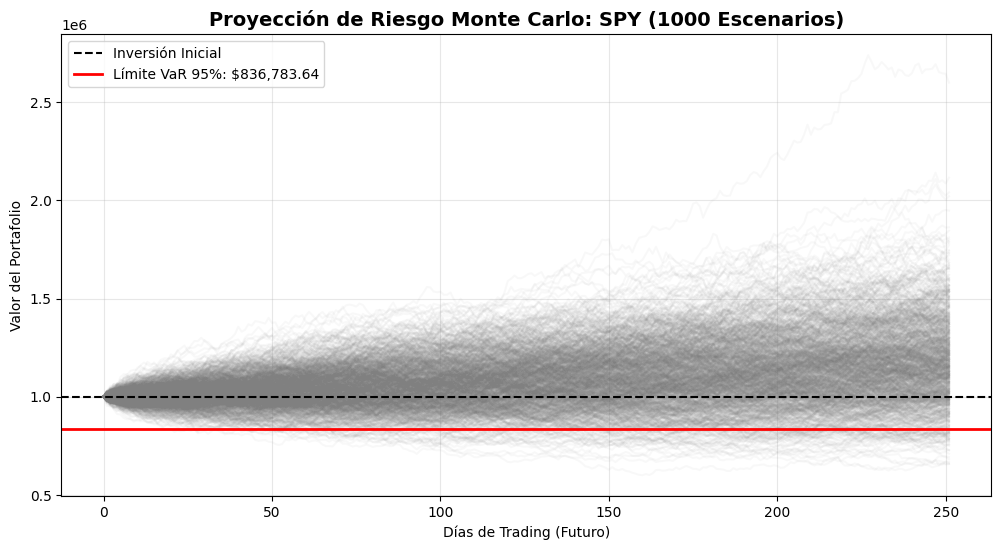

--------------------------------------------------
REPORTE DE RIESGO PARA: SPY
--------------------------------------------------
Inversión Inicial:   $1,000,000.00
Valor Esperado (Avg):$1,180,969.77
VaR (95% Confianza): $163,216.36
INTERPRETACIÓN: Con un 95% de probabilidad, tu pérdida máxima no excederá $163,216.36 en un año.
--------------------------------------------------


In [1]:
# @title MVP: Simulación Monte Carlo para Evaluación de Riesgo de Mercado (VaR)
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import norm

# --- CONFIGURACIÓN ---
TICKER = "SPY"  # ETF del S&P 500 (o cambia a "WALMEX.MX", "AMZN", etc.)
TIMEFRAME_YEARS = 1 # Años de historia para calcular volatilidad
SIMULATIONS = 1000  # Número de escenarios futuros
DAYS_AHEAD = 252    # Días a proyectar (1 año bursátil)
INVERSION_INICIAL = 1000000 # 1 Millón (USD/MXN)

# 1. INGESTA DE DATOS REALES
print(f"Descargando datos para {TICKER}...")
start_date = (datetime.now() - timedelta(days=TIMEFRAME_YEARS*365)).strftime('%Y-%m-%d')
data = yf.download(TICKER, start=start_date, progress=False)['Close']

# Cálculo de Retornos Logarítmicos
log_returns = np.log(1 + data.pct_change())

# Parámetros Estadísticos (Drift y Volatilidad)
u = log_returns.mean()
var = log_returns.var()
drift = u - (0.5 * var)
stdev = log_returns.std()

# Conversión a arrays de numpy para velocidad
drift = np.array(drift)
stdev = np.array(stdev)

# 2. MOTOR DE SIMULACIÓN (Movimiento Browniano Geométrico)
# Z es el componente aleatorio (Shock de mercado)
Z = norm.ppf(np.random.rand(DAYS_AHEAD, SIMULATIONS))
daily_returns = np.exp(drift + stdev * Z)

# Proyección de Precios
price_paths = np.zeros_like(daily_returns)
price_paths[0] = data.iloc[-1] # Precio actual como punto de partida

for t in range(1, DAYS_AHEAD):
    price_paths[t] = price_paths[t-1] * daily_returns[t]

# 3. ANÁLISIS DE RESULTADOS
final_prices = price_paths[-1] * (INVERSION_INICIAL / price_paths[0])
var_95 = INVERSION_INICIAL - np.percentile(final_prices, 5) # Value at Risk 95%
promedio_esperado = np.mean(final_prices)

# 4. VISUALIZACIÓN PROFESIONAL
plt.figure(figsize=(12, 6))
plt.plot(price_paths * (INVERSION_INICIAL / price_paths[0]), alpha=0.05, color='gray') # Escenarios
plt.axhline(y=INVERSION_INICIAL, color='black', linestyle='--', label='Inversión Inicial')
plt.axhline(y=np.percentile(final_prices, 5), color='red', linewidth=2, label=f'Límite VaR 95%: ${np.percentile(final_prices, 5):,.2f}')
plt.title(f"Proyección de Riesgo Monte Carlo: {TICKER} ({SIMULATIONS} Escenarios)", fontsize=14, fontweight='bold')
plt.xlabel("Días de Trading (Futuro)")
plt.ylabel("Valor del Portafolio")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Reporte de Consola
print("-" * 50)
print(f"REPORTE DE RIESGO PARA: {TICKER}")
print("-" * 50)
print(f"Inversión Inicial:   ${INVERSION_INICIAL:,.2f}")
print(f"Valor Esperado (Avg):${promedio_esperado:,.2f}")
print(f"VaR (95% Confianza): ${var_95:,.2f}")
print(f"INTERPRETACIÓN: Con un 95% de probabilidad, tu pérdida máxima no excederá ${var_95:,.2f} en un año.")
print("-" * 50)